In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
!pip install opencv-python -q

In [3]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from random import shuffle
from PIL import Image
from ipywidgets import IntProgress, HTML, VBox
from IPython.display import display

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from transformers import ViTForImageClassification, AdamW
import copy


%matplotlib inline

In [4]:
TARGET_SIZE = (224, 224) 
INPUT_SIZE = (224, 224) 

DATA_DIR = r"C:\Users\Oleg\Desktop\Caltech256"

train_dir = r"C:\Users\Oleg\Desktop\Caltech256\train"
test_dir = r"C:\Users\Oleg\Desktop\Caltech256\test"
val_dir = r"C:\Users\Oleg\Desktop\Caltech256\valid"
print(train_dir, "    ", test_dir, "    ", val_dir)

C:\Users\Oleg\Desktop\Caltech256\train      C:\Users\Oleg\Desktop\Caltech256\test      C:\Users\Oleg\Desktop\Caltech256\valid


In [5]:
# Training settings
batch_size = 16
epochs = 10
lr = 3e-5
gamma = 0.7
seed = 42
device = 'cuda'
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [6]:
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

In [7]:
IMG_SIZE=224 
train_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

In [8]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs) 
val_dataset = datasets.ImageFolder(root=val_dir, transform=test_transforms)
val_loader  = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, **kwargs) 

In [9]:
print(len(train_dataset), len(test_dataset), len(val_dataset))

21315 6272 3020


In [10]:
num_classes=len(train_dataset.classes)
print(num_classes)

257


In [11]:
criterion = nn.CrossEntropyLoss()

In [12]:
def test(model, loader, dataset):
    epoch_val_accuracy = 0
    epoch_val_loss = 0
    model.eval()
    with torch.no_grad():
        for data, label in loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().sum()
            epoch_val_accuracy += acc
            epoch_val_loss += val_loss
    epoch_val_accuracy /= len(dataset)
    epoch_val_loss /= len(dataset)
    return epoch_val_accuracy,epoch_val_loss

In [13]:
def train(model, n_epochs=epochs, learningrate=lr, val_loader=val_loader):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learningrate)
    best_acc = 0
    best_model = None
    
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        model.train()
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            loss = criterion(output, label)            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc = (output.argmax(dim=1) == label).float().sum()
            epoch_accuracy += acc
            epoch_loss += loss
        epoch_accuracy /= len(train_dataset)
        epoch_loss /= len(train_dataset)
        epoch_val_accuracy, epoch_val_loss = test(model, val_loader, val_dataset)
        train_loss_history.append(epoch_loss)
        val_loss_history.append(epoch_val_loss)
        train_acc_history.append(epoch_accuracy)
        val_acc_history.append(epoch_val_accuracy)
        print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n") 
        if best_acc < epoch_val_accuracy:
            best_acc = epoch_val_accuracy
            best_model = copy.deepcopy(model.state_dict())

    if best_model is not None:
        model.load_state_dict(best_model)
        print(f"Best acc:{best_acc}")
        epoch_val_accuracy, epoch_val_loss = test(model, val_loader, val_dataset)
        print(f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n")
    else:
        print(f"No best model Best acc:{best_acc}")
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [14]:
import timm
timm.list_models()

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw

In [15]:
model=timm.create_model('swin_tiny_patch4_window7_224', pretrained=True) 
print(model)

C:\Users\Oleg\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1)

In [16]:
model.head=nn.Linear(in_features=768, out_features=num_classes)
model=model.to(device)
print(model)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1)

In [17]:
if True:
    img = torch.randn(1, 3, 224, 224).to(device)
    model=model.to(device)
    model.eval()
    f=model.forward(img)
    print(f.shape)
    model.train()

torch.Size([1, 257])


In [18]:
def set_parameter_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [19]:
set_parameter_requires_grad(model, requires_grad=False)
set_parameter_requires_grad(model.head, requires_grad=True)
train(model,1,0.0001)

  0%|          | 0/1333 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2624 - acc: 0.4514 - val_loss : 0.1739 - val_acc: 0.7440

Best acc:0.74403977394104
val_loss : 0.1739 - val_acc: 0.7440



([tensor(0.2624, device='cuda:0', grad_fn=<DivBackward0>)],
 [tensor(0.1739, device='cuda:0')],
 [tensor(0.4514, device='cuda:0')],
 [tensor(0.7440, device='cuda:0')])

In [20]:
set_parameter_requires_grad(model, requires_grad=True)
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train(model,10,0.0001)

  0%|          | 0/1333 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0772 - acc: 0.7150 - val_loss : 0.0399 - val_acc: 0.8377



  0%|          | 0/1333 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0551 - acc: 0.7861 - val_loss : 0.0372 - val_acc: 0.8404



  0%|          | 0/1333 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0468 - acc: 0.8143 - val_loss : 0.0390 - val_acc: 0.8483



  0%|          | 0/1333 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0404 - acc: 0.8383 - val_loss : 0.0378 - val_acc: 0.8411



  0%|          | 0/1333 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0371 - acc: 0.8502 - val_loss : 0.0443 - val_acc: 0.8285



  0%|          | 0/1333 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0344 - acc: 0.8618 - val_loss : 0.0405 - val_acc: 0.8421



  0%|          | 0/1333 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0338 - acc: 0.8653 - val_loss : 0.0419 - val_acc: 0.8371



  0%|          | 0/1333 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0306 - acc: 0.8754 - val_loss : 0.0456 - val_acc: 0.8338



  0%|          | 0/1333 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.0304 - acc: 0.8805 - val_loss : 0.0438 - val_acc: 0.8417



  0%|          | 0/1333 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.0278 - acc: 0.8891 - val_loss : 0.0455 - val_acc: 0.8268

Best acc:0.8483443856239319
val_loss : 0.0390 - val_acc: 0.8483



In [21]:
test_accuracy,test_loss=test(model, test_loader, test_dataset)
print(f"test_loss : {test_loss:.4f} - test_acc: {test_accuracy:.4f}\n")

test_loss : 0.0396 - test_acc: 0.8369



In [22]:
PATH = "swin_tiny_patch4_window7_224-caltech256-e10-lr0001-t83.pt"
torch.save(model, PATH)

In [46]:
loss_train_hist = [x.item() for x in train_loss_history]
loss_train_hist.insert(0, 0.2624)
loss_val_hist = [x.item() for x in val_loss_history]
loss_val_hist.insert(0, 0.1739)
acc_train_hist = [x.item() for x in train_acc_history]
acc_train_hist.insert(0, 0.4514)
acc_val_hist = [x.item() for x in val_acc_history]
acc_val_hist.insert(0, 0.7440)

In [47]:
loss_val_hist

[0.1739,
 0.039861779659986496,
 0.03718104213476181,
 0.038958996534347534,
 0.0378052294254303,
 0.04430437833070755,
 0.04054427146911621,
 0.0418538823723793,
 0.04557953402400017,
 0.043828751891851425,
 0.04545026272535324]

In [48]:
acc_train_hist

[0.4514,
 0.7150363326072693,
 0.7860661149024963,
 0.8143091201782227,
 0.8383297920227051,
 0.8501993417739868,
 0.8618343472480774,
 0.8653060793876648,
 0.8754398226737976,
 0.8805066347122192,
 0.8891390562057495]

In [49]:
acc_val_hist

[0.744,
 0.8377483487129211,
 0.8403973579406738,
 0.8483443856239319,
 0.8410596251487732,
 0.8284768462181091,
 0.8420529961585999,
 0.8370860815048218,
 0.8337748646736145,
 0.8417218923568726,
 0.8268212080001831]

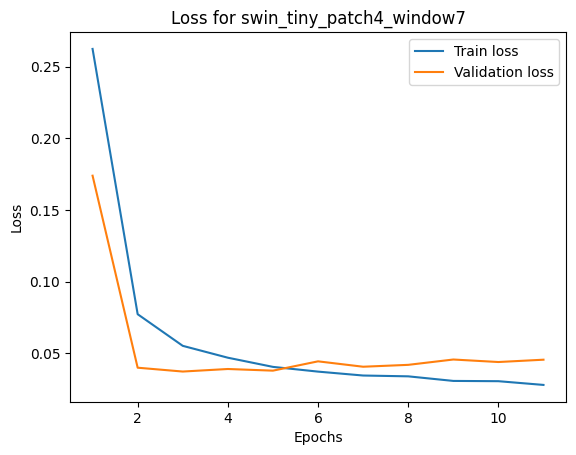

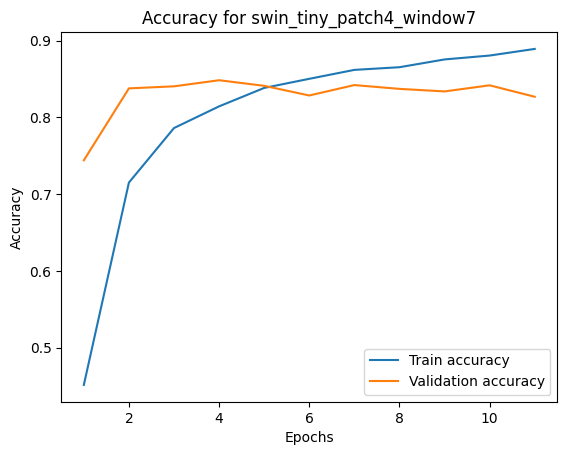

In [51]:
n_epochs = len(loss_train_hist)

# Построим график для значения loss
plt.plot(range(1, n_epochs+1), loss_train_hist, label='Train loss')
plt.plot(range(1, n_epochs+1), loss_val_hist, label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for swin_tiny_patch4_window7')
plt.show()

# Построим график для значения accuracy
plt.plot(range(1, n_epochs+1), acc_train_hist, label='Train accuracy')
plt.plot(range(1, n_epochs+1), acc_val_hist, label='Validation accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for swin_tiny_patch4_window7')
plt.show()